In [1]:
import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam  # Correct import
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")

def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d', '', sms)
    sms = re.sub('_\d\d', '', sms)
    sms = re.sub('_\d', '', sms)
    return sms

### Getting the csv data loaded
dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)

### Getting the Dlib Shape predictor!
dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path = './shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)

### Getting the Xpure loaded
pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path, True)

### Getting the Xdata loaded
dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)

### Getting the Ydata loaded
dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)

print("Data Downloaded!")

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true, y_predicted):
    cm = metrics.confusion_matrix(y_true, y_predicted)
    print("Plotting the Confusion Matrix")
    labels = list(label_map.values())
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig = plt.figure()
    res = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], labels, va='center')
    plt.title('Confusion Matrix - TestData')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def plot_graphs(history, best):
    plt.figure(figsize=[10, 4])
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])  # Change 'acc' to 'accuracy'
    plt.plot(history.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.title('model accuracy across training\n best accuracy of %.02f' % best[1])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss across training\n best loss of %.02f' % best[0])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Integer to Label Mapping
label_map = {0: "ANGRY", 1: "HAPPY", 2: "SAD", 3: "SURPRISE", 4: "NEUTRAL"}

# Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
    #:type image : cv2 object
    #:rtype landmarks : list of tuples where each tuple represents 
    #                  the x and y co-ordinates of facial keypoints

    # Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
    rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

    # Detect the Faces within the image
    landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
    return image, landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image, face_landmarks):
    """
    :type image_path : str
    :type face_landmarks : list of tuples where each tuple represents 
                       the x and y co-ordinates of facial keypoints
    :rtype : None
    """
    radius = -4
    circle_thickness = 1
    image_copy = image.copy()
    for (x, y) in face_landmarks:
        cv2.circle(image_copy, (x, y), circle_thickness, (255, 0, 0), radius)

    plt.imshow(image_copy, interpolation='nearest')
    plt.show()

"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""
def landmarks_edist(face_landmarks):
    e_dist = []
    for i in range(len(face_landmarks)):
        for j in range(len(face_landmarks)):
            if i != j:
                e_dist.append(distance.euclidean(face_landmarks[i], face_landmarks[j]))
    return e_dist

def compare_learning(mlp, lm, cnn, vgg):  # there's one model missing: MLP from pixels
    # summarize history for accuracy
    plt.plot(vgg.history['val_accuracy'],)  # Change 'val_acc' to 'val_accuracy'
    plt.plot(cnn.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.plot(mlp.history['val_accuracy'],)  # Change 'val_acc' to 'val_accuracy'
    plt.plot(lm.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.ylabel('validation accuracy')
    plt.xlabel('epoch')
    plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1, 1])
    plt.xticks(range(0, epochs + 1, 5), range(0, epochs + 1, 5))
    plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31906/1051343267.py:47: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d\d', '', sms)
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31906/1051343267.py:48: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d', '', sms)
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31906/1051343267.py:49: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d', '', sms)


Data Downloaded!


In [25]:
# training related  
epochs, batch_size = 20, 64
# testing related
test_ratio = .1
# categories to predict 
n_emotion_labels = 5 
# shape of images 
width, height = 48, 48

In [26]:
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

# Load the data (Distances between facial Landmarks)
dataX_lm = np.load('./dataX.npy')
dataY_lm = np.load('./dataY.npy')

# convert labels to one hot encoding
y_onehot_lm = to_categorical(dataY_lm, len(set(dataY_lm)))
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(dataX_lm, y_onehot_lm, test_size=0.1, random_state=42)

In [27]:
# split Data into Train, Test (90-10)
lm_scaler = StandardScaler()
lm_scaler.fit(X_train_lm)
X_train_lm = lm_scaler.transform(X_train_lm)
X_test_lm = lm_scaler.transform(X_test_lm)


In [28]:
n_labels = y_train_lm.shape[1]

print("Number of labels:", n_labels)
print("Shape of y_train_lm:", y_train_lm.shape)
print("Shape of y_test_lm:", y_test_lm.shape)

# Building the model
lm_model = Sequential()
lm_model.add(Dense(5120, activation='relu', kernel_initializer='glorot_normal', input_shape=(X_train_lm.shape[1],)))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(512, kernel_initializer='glorot_normal', activation='relu'))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
lm_model.add(Dropout(0.2))
lm_model.add(Dense(n_labels, activation='softmax'))

Number of labels: 5
Shape of y_train_lm: (18000, 5)
Shape of y_test_lm: (2000, 5)


In [30]:
# Compiling the model with SGD optimizer and categorical crossentropy loss
lm_model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

# Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_lm_model.keras', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# Training the model
lm_history = lm_model.fit(X_train_lm, y_train_lm, batch_size=batch_size, epochs=epochs, 
                          verbose=1, callbacks=[checkpoint], validation_data=(X_test_lm, y_test_lm), shuffle=True)

Epoch 1/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3222 - loss: 1.6000
Epoch 1: val_loss improved from inf to 1.29005, saving model to best_lm_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3226 - loss: 1.5992 - val_accuracy: 0.4540 - val_loss: 1.2900
Epoch 2/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4362 - loss: 1.3565
Epoch 2: val_loss improved from 1.29005 to 1.25359, saving model to best_lm_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4363 - loss: 1.3564 - val_accuracy: 0.4750 - val_loss: 1.2536
Epoch 3/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4400 - loss: 1.3220
Epoch 3: val_loss improved from 1.25359 to 1.23637, saving model to best_lm_model.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.4401 - loss: 1.3219 - val_accuracy: 0.4830 - val_loss: 1.2364
Epoch 4/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4749 - loss: 1.2771
Epoch 4: val_loss improved from 1.2363

In [31]:
lm_performance = lm_model.evaluate(X_test_lm, y_test_lm, batch_size=64)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5401 - loss: 1.1475


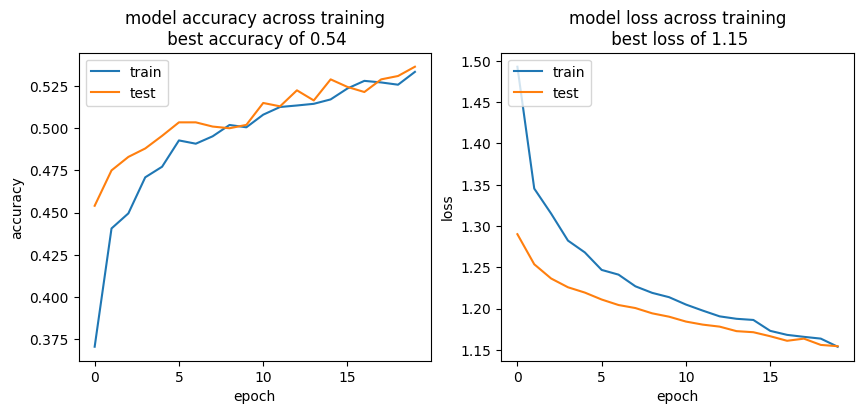

In [32]:
plot_graphs(lm_history, lm_performance)